## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from datasets import load_from_disk

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.string_edit_metrics import get_string_edit_metrics, get_string_edit_metrics_ortho_and_norm
from normalization.whisper_normalization import get_whisper_normalizer
from utils.whisper_hallucinations.eval_filter_criterion import eval_filter_criterion
from utils.notebook_utils import listen_to_audio

whisper_norm = get_whisper_normalizer("english")
sns.set_theme(context="paper", style="ticks")

## Load cached dataset

In [4]:
dataset_name = "ami_validation"

savepath = f"notebooks/data/whisper_hallucinations_cached_ds/{dataset_name}"
ds = load_from_disk(savepath)

ds.features

{'text': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'teacher_text': Value(dtype='string', id=None),
 'teacher_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'audio_length': Value(dtype='float64', id=None),
 'n_tokens_labels': Value(dtype='int64', id=None),
 'n_tokens_teacher': Value(dtype='int64', id=None),
 'n_overlaps': Value(dtype='int64', id=None),
 'is_fast_utterance': Value(dtype='bool', id=None),
 'diff_n_tokens': Value(dtype='int64', id=None),
 'max_token_repetitions_labels': Value(dtype='int64', id=None),
 'max_token_repetitions_teacher': Value(dtype='int64', id=None)}

## Convert to DataFrame

In [5]:
df = pd.DataFrame({col: ds[col] for col in ds.features.keys() if col != "audio"})

df.head()

,text,labels,teacher_text,teacher_labels,audio_length,n_tokens_labels,n_tokens_teacher,n_overlaps,is_fast_utterance,diff_n_tokens,max_token_repetitions_labels,max_token_repetitions_teacher
0,but like mobile phones have screens and they'r...,"[50258, 50363, 5955, 411, 6013, 10216, 362, 11...",but like mobile phones have screens and they'...,"[50258, 50363, 457, 411, 6013, 10216, 362, 111...",2.68,14,15,0,False,1,1,1
1,mm,"[50258, 50363, 2174, 50257]",you,"[50258, 50363, 291, 50257]",0.15,4,4,0,False,0,1,1
2,furry,"[50258, 50363, 69, 30614, 50257]",furry.,"[50258, 50363, 47073, 13, 50257]",0.52,5,5,0,False,0,1,1
3,yeah,"[50258, 50363, 19650, 50257]",yeah.,"[50258, 50363, 1338, 13, 50257]",1.86,4,5,0,False,1,1,1
4,i mean it just seems like yeah,"[50258, 50363, 72, 914, 309, 445, 2544, 411, 1...",i mean it just seems like... yeah.,"[50258, 50363, 741, 914, 309, 445, 2544, 411, ...",2.27,10,12,0,False,2,1,1


## First analysis

In [6]:
dict_string_edit_metrics = get_string_edit_metrics_ortho_and_norm(references=df["text"], predictions=df["teacher_text"], norm_fn=get_whisper_normalizer("english"))

dict_string_edit_metrics

{'WER ortho (%)': 38.891872821290534,
 'Sub ortho (%)': 24.286752393289312,
 'Del ortho (%)': 11.956441607953408,
 'Ins ortho (%)': 2.648678820047813,
 'WER (%)': 18.36682750941195,
 'Sub (%)': 6.105307810594411,
 'Del (%)': 8.533856514131184,
 'Ins (%)': 3.727663184686357}

**Observation:** Using the Whisper normalizer drastically decreased the different string edit metric errors. Since 1-best operated without any normalization, we will focus on the orthographic WER in this study.

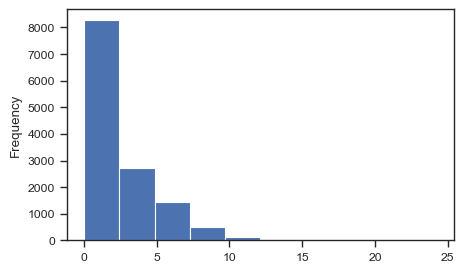

In [7]:
plt.figure(figsize=(5, 3))
df["audio_length"].plot.hist();

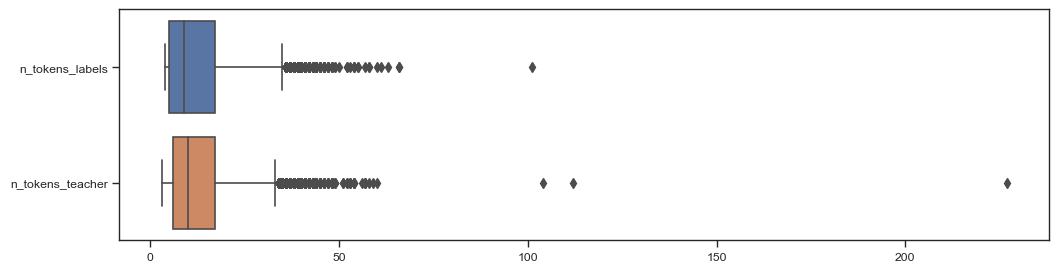

In [8]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=df[["n_tokens_labels", "n_tokens_teacher"]], orient="h");

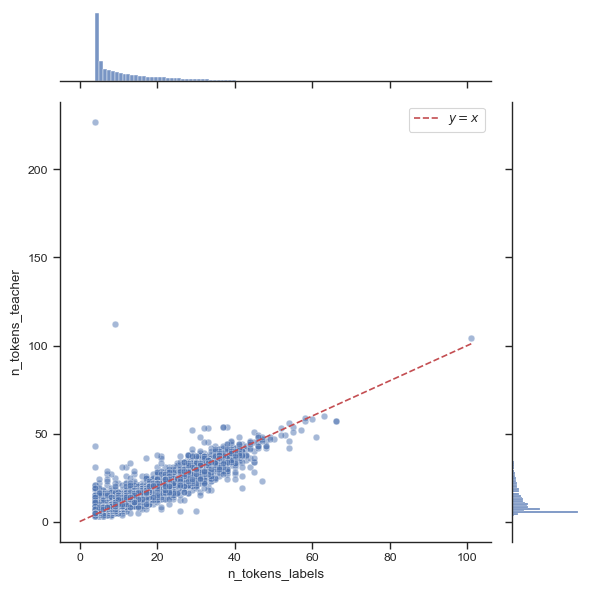

In [9]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
plt.tight_layout()

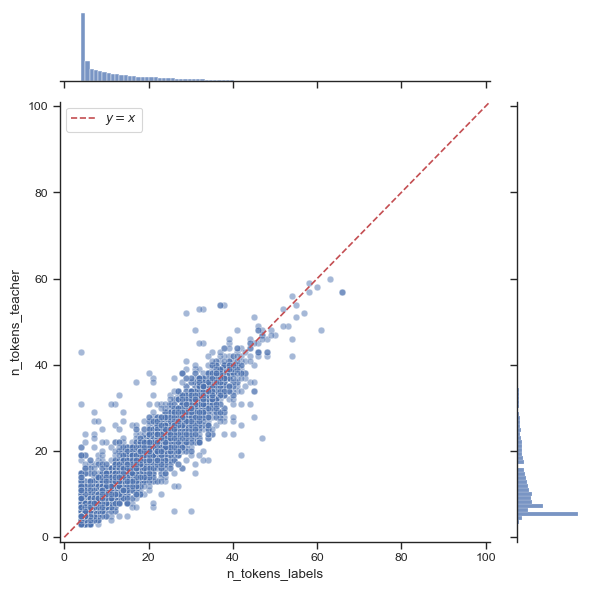

In [10]:
x_col = "n_tokens_labels"
y_col = "n_tokens_teacher"

sns.jointplot(data=df, x=x_col, y=y_col, alpha=0.5)
line_max_coord = min(df[x_col].max(), df[y_col].max())
plt.plot([0, line_max_coord], [0, line_max_coord], 'r--', label=r"$y=x$")
plt.legend()
plt.xlim(-1, line_max_coord)
plt.ylim(-1, line_max_coord)
plt.tight_layout()

In [11]:
df["diff_n_tokens"].describe()

count    13098.000000
mean         0.646053
std          3.309482
min        -24.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        223.000000
Name: diff_n_tokens, dtype: float64

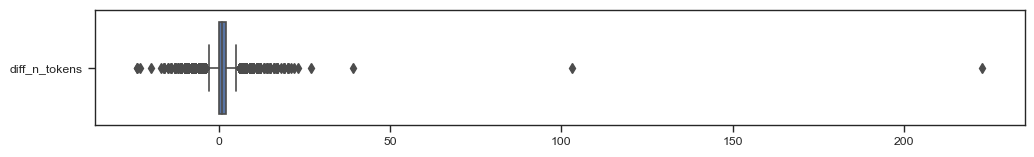

In [12]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h");

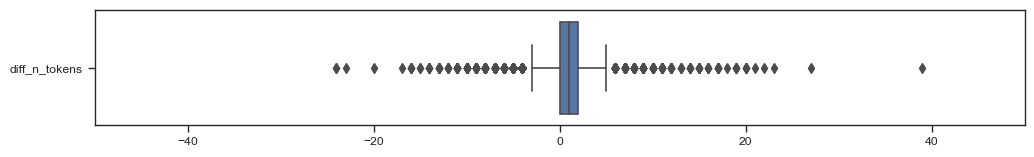

In [13]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_n_tokens"]], orient="h")
plt.xlim(-50, 50);

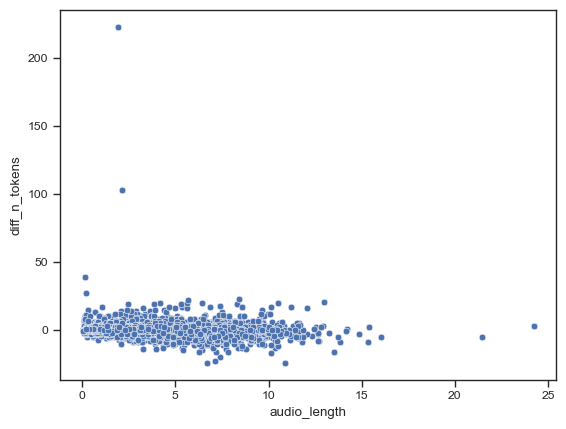

In [14]:
sns.scatterplot(data=df, x="audio_length", y="diff_n_tokens");

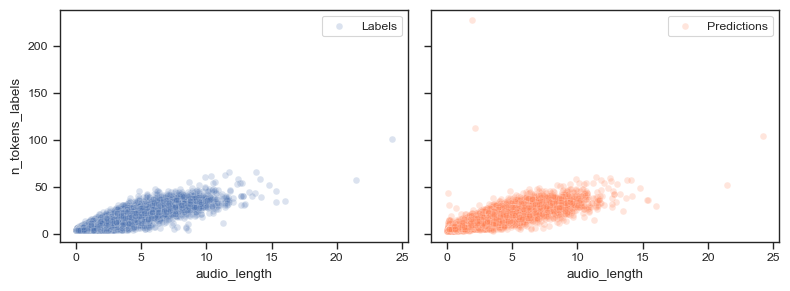

In [15]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="n_tokens_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="n_tokens_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

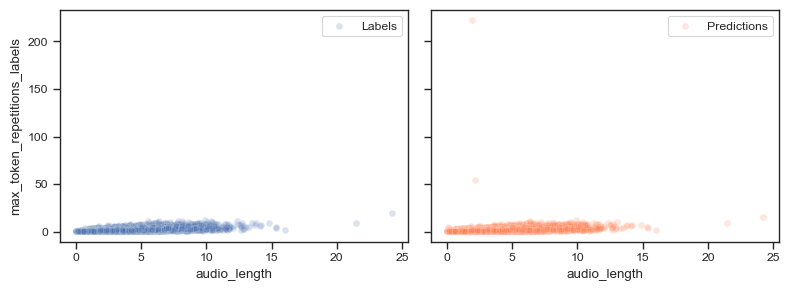

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

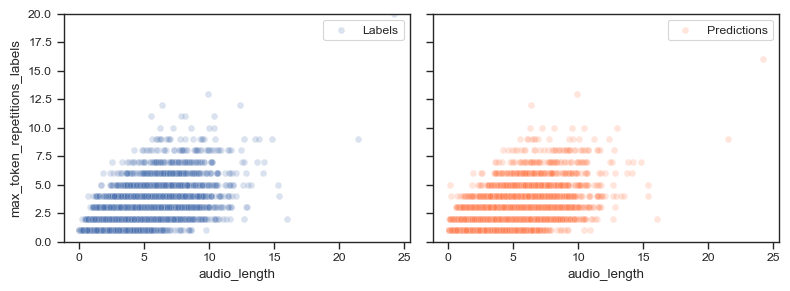

In [17]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="audio_length", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
for ax in axis.flatten():
    ax.set_ylim(0, 20)
fig.tight_layout()

In [18]:
df["diff_max_token_repetitions"] = df["max_token_repetitions_teacher"] - df["max_token_repetitions_labels"]

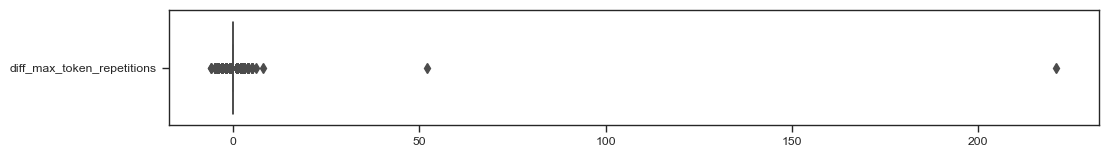

In [19]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_max_token_repetitions"]], orient="h");

(-10.0, 10.0)

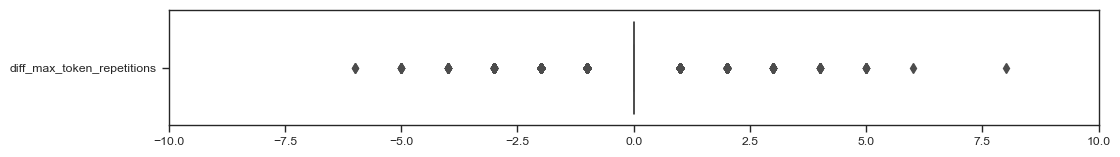

In [20]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(data=df[["diff_max_token_repetitions"]], orient="h")
plt.xlim(-10, 10)

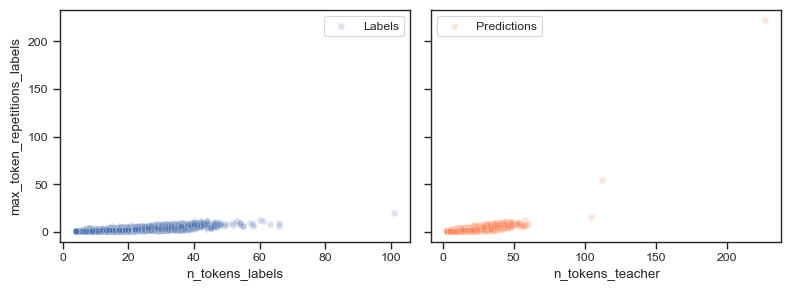

In [21]:
fig, axis = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
sns.scatterplot(data=df, x="n_tokens_labels", y="max_token_repetitions_labels", label="Labels", alpha=0.2, ax=axis[0])
sns.scatterplot(data=df, x="n_tokens_teacher", y="max_token_repetitions_teacher", label="Predictions", c="coral", alpha=0.2, ax=axis[1])
fig.tight_layout()

## Criteria for filtering

### `high_diff_n_tokens`

In [43]:
DELTA_N_TOKENS = round(df["diff_n_tokens"].std() + df["diff_n_tokens"].mean())

DELTA_N_TOKENS

4

In [44]:
df["high_diff_n_tokens"] = (df["diff_n_tokens"] > DELTA_N_TOKENS)

In [45]:
df["high_diff_n_tokens"].value_counts()

False    12697
True       401
Name: high_diff_n_tokens, dtype: int64

In [46]:
df_candidates = df[df["high_diff_n_tokens"]]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 59
Reference:  um oh we just
Prediction:   um, i will just have to zoom.

Idx = 99
Reference:  this is yeah well like a cat you know soft yeah
Prediction:   yeah, well, like a cat, you know. soft, yeah. ha ha.

Idx = 156
Reference:  okay my favourite animal is see
Prediction:   okay, my favorite animal is... let's see.

Idx = 246
Reference:  make sure my things here
Prediction:   make sure i have all of my things here.

Idx = 267
Reference:  i don't know how intelligent that one looks
Prediction:   i don't know how intelligent that one looks. ha ha ha.

Idx = 271
Reference:  does anyone know what they wanna draw
Prediction:   does anyone know what they want to troll?

Idx = 287
Reference:  oh my gosh this is disastrous
Prediction:   oh shoot, oh my gosh, this is disastrous.

Idx = 298
Reference:  i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:   i don't, yeah, i mean, but like, i mean, just, i mean, like your pho

In [47]:
list_idx_to_listen = df_candidates.index[:10]

listen_to_audio(ds, list_idx_to_listen, pred_col="teacher_text")

Idx: 59
Reference: um oh we just
Prediction:  um, i will just have to zoom.



Idx: 99
Reference: this is yeah well like a cat you know soft yeah
Prediction:  yeah, well, like a cat, you know. soft, yeah. ha ha.



Idx: 156
Reference: okay my favourite animal is see
Prediction:  okay, my favorite animal is... let's see.



Idx: 246
Reference: make sure my things here
Prediction:  make sure i have all of my things here.



Idx: 267
Reference: i don't know how intelligent that one looks
Prediction:  i don't know how intelligent that one looks. ha ha ha.



Idx: 271
Reference: does anyone know what they wanna draw
Prediction:  does anyone know what they want to troll?



Idx: 287
Reference: oh my gosh this is disastrous
Prediction:  oh shoot, oh my gosh, this is disastrous.



Idx: 298
Reference: i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:  i don't, yeah, i mean, but like, i mean, just, i mean, like your phone even just has sound, like it can vibrate.



Idx: 300
Reference: that's something we could decide
Prediction:  i think that's something we could decide.



Idx: 308
Reference: a dolphin
Prediction:  a dolphin. ha ha ha.


In [48]:
eval_filter_criterion(ds, filter_fn=lambda x: x["diff_n_tokens"] <= DELTA_N_TOKENS)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 12697
Total audio length after filtering: 510.77 minutes
String edit metrics after filtering:
{'Del (%)': 8.8,
 'Del ortho (%)': 12.32,
 'Ins (%)': 2.26,
 'Ins ortho (%)': 1.25,
 'Sub (%)': 5.8,
 'Sub ortho (%)': 23.74,
 'WER (%)': 16.85,
 'WER ortho (%)': 37.31}

Number of rows removed: 401 (3.06 %)
Total audio length removed: 25.74 minutes (4.80 %)
String edit metrics difference:
{'Del (%)': 0.27,
 'Del ortho (%)': 0.36,
 'Ins (%)': -1.47,
 'Ins ortho (%)': -1.4,
 'Sub (%)': -0.31,
 'Sub ortho (%)': -0.55,
 'WER (%)': -1.52,
 'WER ortho (%)': -1.58}

Relative string edit metrics difference:
{'Del (%)': 0.03,
 'Del ortho (%)': 0.03,
 'Ins (%)': -0.39,
 'Ins

**Observation:** Good criterion. Note that this also tackles the fact that the vanilla Whisper models tend to transcribe even the speeches in the background. By removing them from the training set, we hope to teach Whisper to only focus on the main speaker.

### Difference in max number of repeated tokens

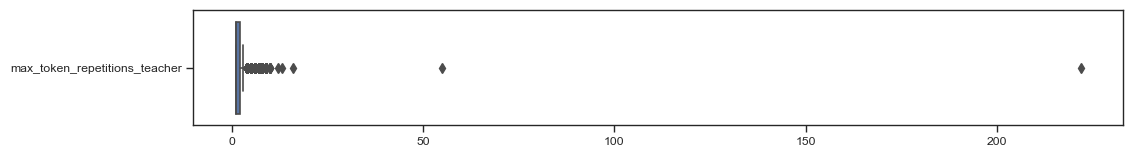

In [28]:
plt.figure(figsize=(12, 1.5));
sns.boxplot(data=df[["max_token_repetitions_teacher"]], orient="h");

In [29]:
MAX_REPETITIONS_TEACHER = 10

df_candidates = df[df["max_token_repetitions_teacher"] >= MAX_REPETITIONS_TEACHER]

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()

Idx = 15
Reference:  he's a i dunno um they're i think it's cool the the um the interaction that or the th things that the reasons people seem to like you know you get ex you know people are sitting on the beach and p they're like oh look there's dolphins and it's kinda like but they're you know they jump around in the water and they're happy and they're mammals
Prediction:   he's a... i don't know. and i think it's cool the interaction that... or the things that the reasons people seem to like, you know... you know, people are sitting on the beach and they're like, oh, look, there's dolphins. it's kind of like... but they're, you know, they jump around in the water and they're happy and... they're mammals.

Idx = 3319
Reference:  yeah about two thirds of the way through the movie 'cause most of the movie is them find trying to find him on the front right
Prediction:   yeah, about two thirds of the way through the movie. because most of the movie is them trying to find him on the front

In [30]:
eval_filter_criterion(ds, filter_fn=lambda x: x["max_token_repetitions_teacher"] < MAX_REPETITIONS_TEACHER)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 13087
Total audio length after filtering: 534.85 minutes
String edit metrics after filtering:
{'Del (%)': 8.55,
 'Del ortho (%)': 11.98,
 'Ins (%)': 3.66,
 'Ins ortho (%)': 2.58,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.31,
 'WER (%)': 18.32,
 'WER ortho (%)': 38.87}

Number of rows removed: 11 (0.08 %)
Total audio length removed: 1.65 minutes (0.31 %)
String edit metrics difference:
{'Del (%)': 0.02,
 'Del ortho (%)': 0.02,
 'Ins (%)': -0.07,
 'Ins ortho (%)': -0.07,
 'Sub (%)': 0.0,
 'Sub ortho (%)': 0.02,
 'WER (%)': -0.05,
 'WER ortho (%)': -0.02}

Relative string edit metrics difference:
{'Del (%)': 0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': -0.02,
 'Ins ort

**Observation:** Not good criterion because a lot of good predictions are removed just because the reference itself is quite long.

### Word per second (WPS)

In [31]:
df["wps"] = df["teacher_text"].str.split(" ").str.len() / df["audio_length"]

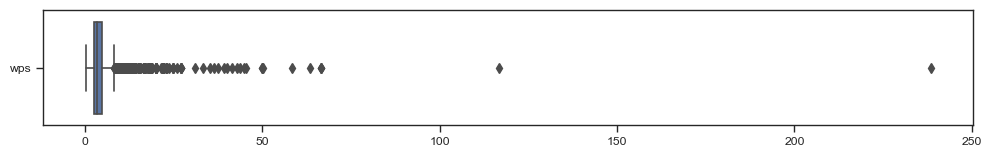

In [32]:
plt.figure(figsize=(12, 1.5));
sns.boxplot(data=df[["wps"]], orient="h");

In [33]:
df_candidates = df[(df["wps"] > 10) & (df["audio_length"] > 1)]
print(len(df_candidates))

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()
    if idx > 10:
        break

3
Idx = 6645
Reference:  um
Prediction:   i'm going to stop there. i'm going to stop there.

Idx = 10258
Reference:  do you want the mouse or do you want me to
Prediction:   do you want the mouse or do you want me to do the mouse?

Idx = 11595
Reference:  d. a. w.
Prediction:   day day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day, day,



**Observations:** Too few filtered examples... Discarded.

### `diff_max_token_repetitions`

In [34]:
MAX_DIFF_MAX_TOKEN_REPETTIONS = 3

df_candidates = df[df["diff_max_token_repetitions"] >= MAX_DIFF_MAX_TOKEN_REPETTIONS]
print(len(df_candidates))

for idx in range(len(df_candidates)):
    print(f"Idx = {df_candidates.iloc[idx].name}")
    print("Reference: ", df_candidates.iloc[idx]["text"])
    print("Prediction: ", df_candidates.iloc[idx]["teacher_text"])
    print()
    if idx > 10:
        break

46
Idx = 298
Reference:  i don't yeah i mean it but like i mean just i mean like your phone even just has so like it can vibrate
Prediction:   i don't, yeah, i mean, but like, i mean, just, i mean, like your phone even just has sound, like it can vibrate.

Idx = 463
Reference:  what if yeah what if the squishy oh so so you're saying the squishy part's like detachable
Prediction:   what if, yeah, what if the squishy, oh, sorry, so you're saying the squishy part's like detachable?

Idx = 533
Reference:  so anyway if well we just we need to okay so if we're not gonna have a screen i think i was thinking okay
Prediction:   so anyway, well, we just, we need to, okay, so if we're not gonna have a screen, i think, i was thinking, okay.

Idx = 750
Reference:  um you know channels one two three four five six seven eight nine
Prediction:   channels 1, 2, 3, 4, 5, 6, 7, 8, 9.

Idx = 1045
Reference:  yeah yeah no okay
Prediction:   that's the whole point, right? yeah, yeah, no, okay.

Idx = 1149
R

In [35]:
eval_filter_criterion(ds, filter_fn=lambda x: x["max_token_repetitions_teacher"] - x["max_token_repetitions_labels"] < MAX_DIFF_MAX_TOKEN_REPETTIONS)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 13052
Total audio length after filtering: 532.29 minutes
String edit metrics after filtering:
{'Del (%)': 8.56,
 'Del ortho (%)': 12.0,
 'Ins (%)': 3.46,
 'Ins ortho (%)': 2.38,
 'Sub (%)': 6.06,
 'Sub ortho (%)': 24.16,
 'WER (%)': 18.08,
 'WER ortho (%)': 38.54}

Number of rows removed: 46 (0.35 %)
Total audio length removed: 4.21 minutes (0.79 %)
String edit metrics difference:
{'Del (%)': 0.03,
 'Del ortho (%)': 0.04,
 'Ins (%)': -0.27,
 'Ins ortho (%)': -0.27,
 'Sub (%)': -0.05,
 'Sub ortho (%)': -0.13,
 'WER (%)': -0.29,
 'WER ortho (%)': -0.35}

Relative string edit metrics difference:
{'Del (%)': 0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': -0.07,
 'Ins o

### `n_overlaps`

In [36]:
df["n_overlaps"].value_counts()

0    13081
1       17
Name: n_overlaps, dtype: int64

In [37]:
ds_candidate = ds.filter(lambda x: x["n_overlaps"] >= 1)

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Index:  0
Reference:  no uh automatic uh coffee machines
Pred:   now, automatic coffee machines.

Index:  1
Reference:  oh all okay all of us
Pred:   oh, okay, all of us.

Index:  2
Reference:  yeah just is that okay
Pred:   yeah, just, is that okay?

Index:  3
Reference:  wha what um well probably our target group and how it's gonna going to appeal to our target group and i dunno the the s the buttons and what it does and that sort of thing
Pred:   what, well probably our target group and how it's going to appeal to our target group in, i don't know, the buttons and what it does and that sort of thing.

Index:  4
Reference:  like uh we could do i'm trying to think of other sha like fruits that are oddly shaped
Pred:   like, we could do, i'm trying to think of other shape, like fruits that are oddly shaped.

Index:  5
Reference:  yeah um f you guys wanna give a prototype presentation of
Pred:   yeah, you guys want to give a prototype presentation of?

Index:  6
Reference:  um so uh i c

In [38]:
eval_filter_criterion(ds, filter_fn=lambda x: x["n_overlaps"] == 0)

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 13081
Total audio length after filtering: 534.90 minutes
String edit metrics after filtering:
{'Del (%)': 8.54,
 'Del ortho (%)': 11.95,
 'Ins (%)': 3.72,
 'Ins ortho (%)': 2.64,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.28,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.88}

Number of rows removed: 17 (0.13 %)
Total audio length removed: 1.61 minutes (0.30 %)
String edit metrics difference:
{'Del (%)': 0.01,
 'Del ortho (%)': -0.01,
 'Ins (%)': -0.01,
 'Ins ortho (%)': -0.01,
 'Sub (%)': 0.0,
 'Sub ortho (%)': -0.01,
 'WER (%)': 0.0,
 'WER ortho (%)': -0.01}

Relative string edit metrics difference:
{'Del (%)': 0.0,
 'Del ortho (%)': -0.0,
 'Ins (%)': -0.0,
 'Ins ort

### `is_fast_utterance`

In [39]:
df["is_fast_utterance"].value_counts()

False    13084
True        14
Name: is_fast_utterance, dtype: int64

In [40]:
ds_candidate = ds.filter(lambda x: x["is_fast_utterance"])

for idx, row in enumerate(ds_candidate):
    print("Index: ", idx)
    print("Reference: ", row["text"])
    print("Pred: ", row["teacher_text"])
    print()

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Index:  0
Reference:  i mean sh we put some trainee in gisella's office because there is a spare room and that's quite imp yeah
Pred:   i mean, we put some trainee in gisela's office because there is a spare room. and that's quite... and they have a position to complain. yeah.

Index:  1
Reference:  at least at e. p. f. l.
Pred:   please let me know if you have any questions. i'm going to read the d.p.f.

Index:  2
Reference:  mm
Pred:   and i'm not sure if it's but i think it's because of and i think it's because of and i think it's because of and i think it's because of

Index:  3
Reference:  hmm
Pred:   i'm gonna go get some water. i'm gonna go get some water.

Index:  4
Reference:  yeah so uh what we'll do is uh
Pred:   so, what we will do is, we will do is, we will do is, we will do is, we will do is,

Index:  5
Reference:  pirette marianne david david
Pred:   okay, so what's the name of the person who's going to be the judge?

Index:  6
Reference:  i p if i have to choose between

In [41]:
eval_filter_criterion(ds, filter_fn=lambda x: not x["is_fast_utterance"])

Filter:   0%|          | 0/13098 [00:00<?, ? examples/s]

Number of rows before filtering: 13098
Total audio length before filtering: 536.51 minutes
String edit metrics before filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.73,
 'Ins ortho (%)': 2.65,
 'Sub (%)': 6.11,
 'Sub ortho (%)': 24.29,
 'WER (%)': 18.37,
 'WER ortho (%)': 38.89}

Number of rows after filtering: 13084
Total audio length after filtering: 535.70 minutes
String edit metrics after filtering:
{'Del (%)': 8.53,
 'Del ortho (%)': 11.96,
 'Ins (%)': 3.57,
 'Ins ortho (%)': 2.46,
 'Sub (%)': 6.09,
 'Sub ortho (%)': 24.26,
 'WER (%)': 18.2,
 'WER ortho (%)': 38.69}

Number of rows removed: 14 (0.11 %)
Total audio length removed: 0.81 minutes (0.15 %)
String edit metrics difference:
{'Del (%)': 0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': -0.16,
 'Ins ortho (%)': -0.19,
 'Sub (%)': -0.02,
 'Sub ortho (%)': -0.03,
 'WER (%)': -0.17,
 'WER ortho (%)': -0.2}

Relative string edit metrics difference:
{'Del (%)': 0.0,
 'Del ortho (%)': 0.0,
 'Ins (%)': -0.04,
 'Ins orth